In [7]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_17528\4160992139.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [8]:
data = pd.read_csv("BI_ML_2024/HW_4/data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


Посмотрим на количество образцов и признаков:

In [9]:
data.shape

(17996, 17)

Посмотрим есть ли в данных пропущенные значения:

In [10]:
missing_values_sum = data.isnull().sum()
print(missing_values_sum)

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64


Так как у нас довольно много данных уберем пропущенные значения:

In [11]:
df_cleaned = data.dropna()

In [12]:
df_cleaned.shape

(11813, 17)

Посмотрим на наличие выбросов в данных:

Skipping non-numeric column: Artist Name
Skipping non-numeric column: Track Name


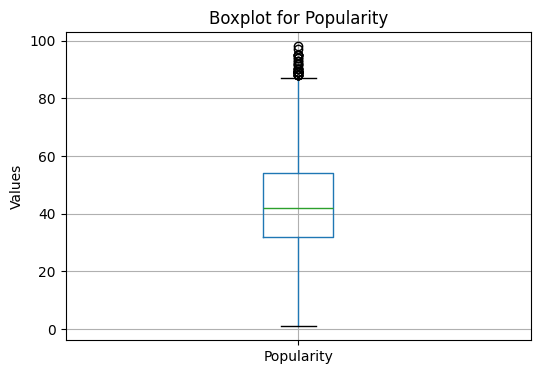

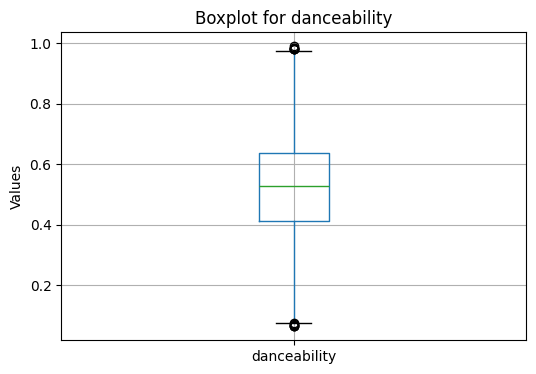

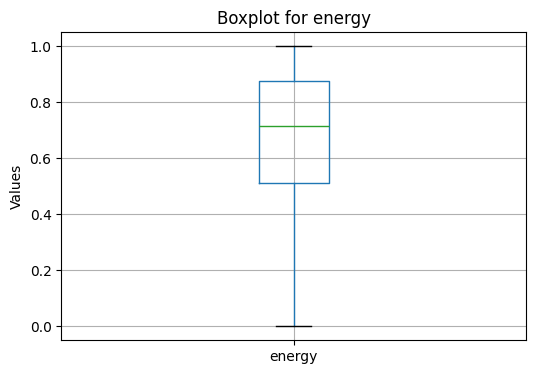

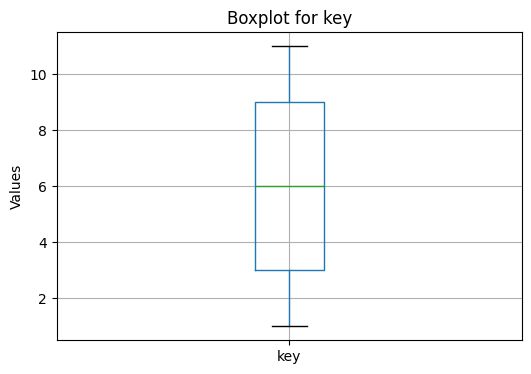

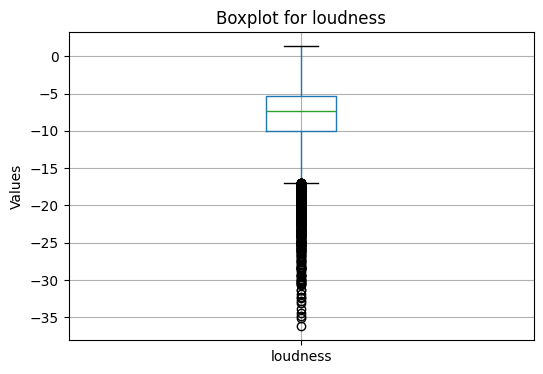

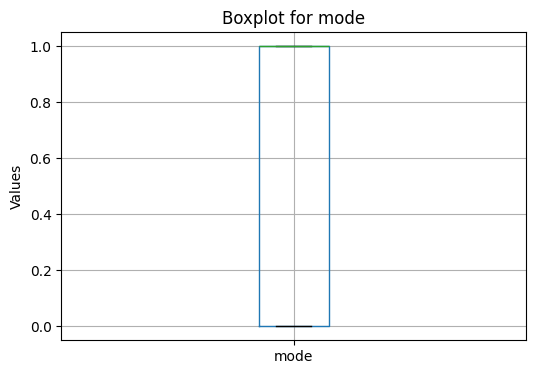

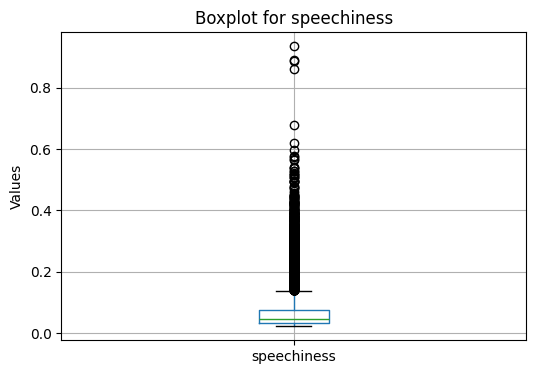

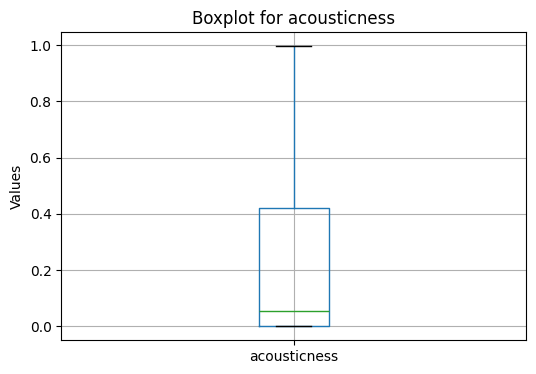

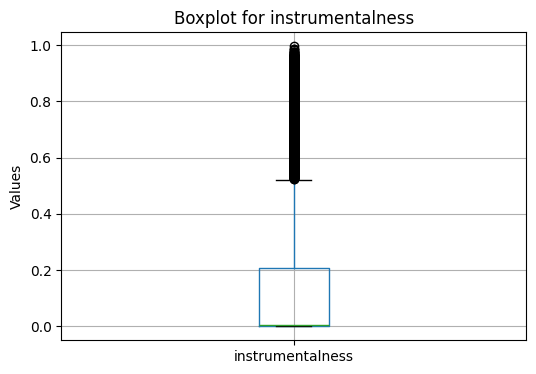

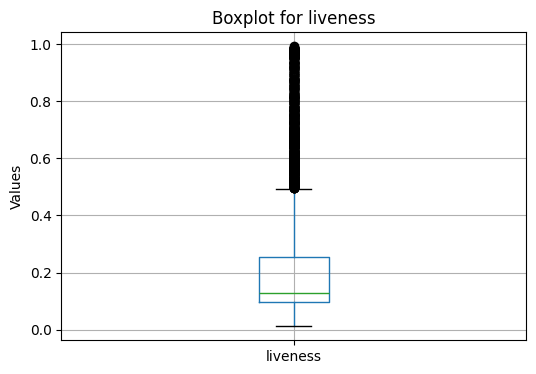

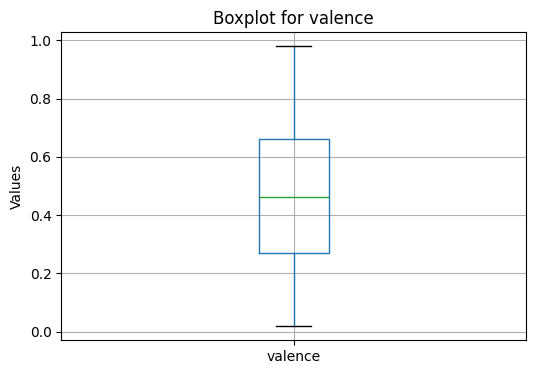

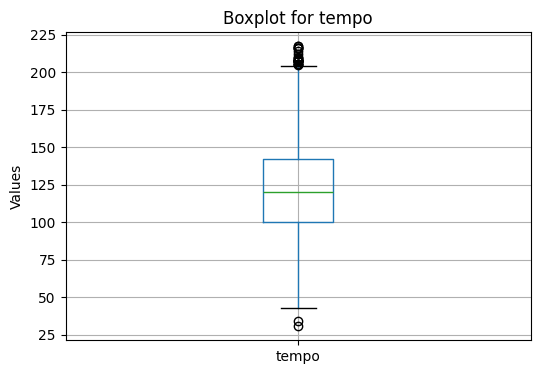

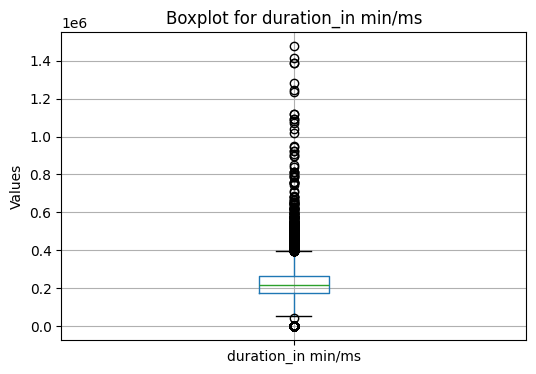

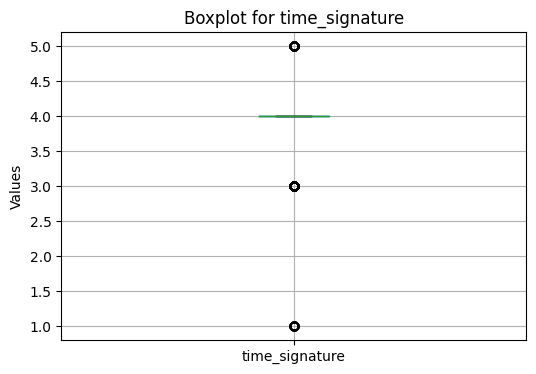

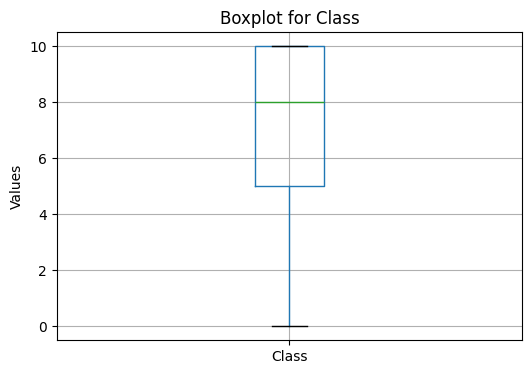

In [13]:
import matplotlib.pyplot as plt

for column in df_cleaned.columns:
    if pd.api.types.is_numeric_dtype(df_cleaned[column]):
        plt.figure(figsize=(6, 4))
        df_cleaned[[column]].boxplot()

        plt.title(f'Boxplot for {column}')
        plt.ylabel('Values')

        plt.show()
    else:
        print(f"Skipping non-numeric column: {column}")

Уберем совесм явные выбросы из данных:

In [14]:
condition = (df_cleaned['speechiness'] < 8)

filtered_df = df_cleaned[condition]

In [15]:
filtered_df.shape

(11813, 17)

Посмотрим на баланс классов в данных:

In [16]:
class_balance = filtered_df['Class'].value_counts()
print(class_balance)

Class
10    3374
6     2039
8     1523
9     1099
1     1037
2      956
5      517
7      464
0      386
3      270
4      148
Name: count, dtype: int64


Видим явный дисбаланс классов, попробуем исправить это в следующем пункте.

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [17]:
columns_to_drop = ['Artist Name', 'Track Name', 'Class']  
X = filtered_df.drop(columns=columns_to_drop)
y = filtered_df['Class']

Предобрабатываем данные для модели:

In [18]:
cat_cols = ["mode", "time_signature", "key"]
num_cols = ["Popularity",	"danceability",
            "energy", "loudness",
            "speechiness",	"acousticness",
            "instrumentalness",	"liveness",	"valence",
            "tempo", "duration_in min/ms"]

In [19]:
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.compose import ColumnTransformer

In [20]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [23]:
#Посмотрим на баланс классов в тренировочных данных
class_balance = y_train.value_counts()
print(class_balance)

Class
10    2686
6     1632
8     1217
9      884
1      810
2      769
5      423
7      381
0      319
3      212
4      117
Name: count, dtype: int64


У нас получились не очень сбалансированные данные, в дальнейшем будем подбирать модель с присвоением веса каждому классу и без.

Для подбора лучшей модели будем использовать GridSearchCV

In [24]:
from sklearn.model_selection import GridSearchCV

In [52]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth' : list(range(1, 50)), 
          'min_samples_split' : list(range(2, 6)),
          'min_samples_leaf' : list(range(1, 4)),
          'class_weight' : ['balanced', None]
          }

criterion: Критерий, используемый для измерения качества разделения в деревьях
max_depth: Максимальная глубина каждого дерева 
min_samples_split: Минимальное количество образцов, требуемое для разделения внутреннего узла дерева
min_samples_leaf: Минимальное количество образцов, требуемое для существования листового узла.
class_weight: Этот параметр отвечает за взвешивание классов. Два значения - 'balanced' и None. Если выбрано 'balanced', модель автоматически вычислит веса классов на основе их частоты в обучающем наборе. Если выбрано None, веса классов не учитываются, и все классы считаются равнозначными.


In [53]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = params, 
                    scoring = 'accuracy',
                    cv = 5)

estimator: модель, для которой проводится поиск оптимальных параметров.

param_grid: Это словарь параметров, которые хотим оптимизировать. 

scoring: Это параметр, который определяет метрику, используемую для оценки качества модели при каждом варьировании параметров. В данном случае, используется 'accuracy', так как я решила что для меня важна точность определения каждого класса.

cv: Это количество разделений (фолдов) при кросс-валидации. В данном случае, используется 5 фолдов. Параметр cv в GridSearchCV указывает, на сколько частей (фолдов) будет разделено обучающее множество в процессе кросс-валидации. 

In [54]:
grid.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='accuracy')

In [55]:
grid.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [56]:
best_rf_params = grid.best_params_
best_rf_model = DecisionTreeClassifier(**best_rf_params)
best_rf_model.fit(X_train_transformed, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=5)

In [57]:
from sklearn.metrics import classification_report


In [58]:
def evaluate_model(model, X_test, y_test, normalize='true', cmap='Blues'):
    y_hat_test = model.predict(X_test)
    
    
    print('Classification Report')
    print('---------------------')
    print(classification_report(y_test, y_hat_test))
    

evaluate_model(best_rf_model, X_test_transformed, y_test)

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        67
           1       0.64      0.03      0.06       227
           2       0.33      0.44      0.38       187
           3       0.69      0.66      0.67        58
           4       0.44      0.45      0.44        31
           5       0.53      0.51      0.52        94
           6       0.37      0.25      0.29       407
           7       0.94      0.93      0.93        83
           8       0.57      0.53      0.55       306
           9       0.39      0.28      0.32       215
          10       0.41      0.64      0.50       688

    accuracy                           0.46      2363
   macro avg       0.54      0.49      0.49      2363
weighted avg       0.48      0.46      0.43      2363



Визуализируем получившееся дерево:

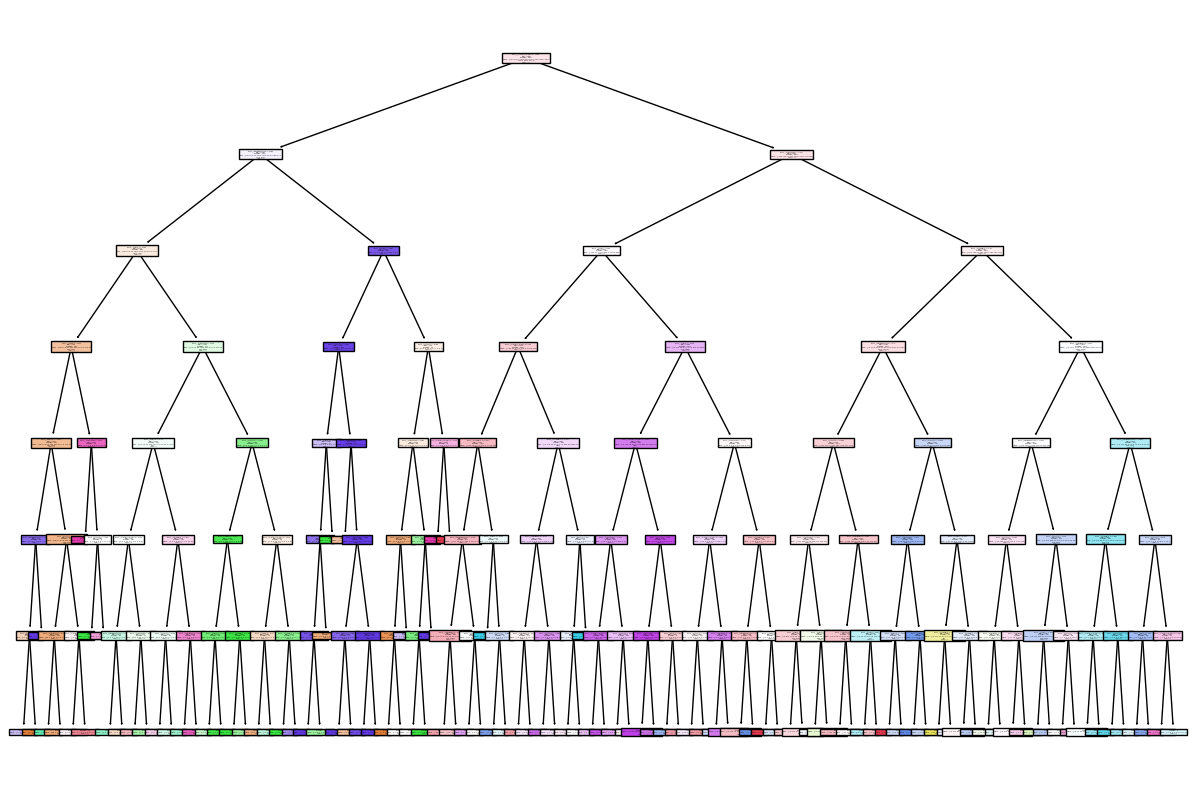

In [76]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(best_rf_model, filled=True, feature_names=preprocessor.get_feature_names_out(), class_names=list(map(str, best_rf_model.classes_)))
plt.show()

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Шрек
2. Гарри Поттер
3. Райа и последний дракон